# Import

In [2]:
import numpy as np
from sklearn.metrics import roc_curve
from sklearn.neighbors import KNeighborsClassifier
import random
import matplotlib.patheffects as PathEffects

In [3]:
from tensorflow.keras.layers import Input, Conv2D, Lambda, Dense, Flatten,MaxPooling2D, concatenate, Dropout
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import SGD,Adam
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.applications import InceptionV3
import os
import pickle
import matplotlib.pyplot as plt

In [4]:
from itertools import permutations
import seaborn as sns
from keras.datasets import mnist
from sklearn.manifold import TSNE
from sklearn.svm import SVC

# Load Data

In [5]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [6]:
#added cell
x_train = x_train/255.0
x_test = x_test/255.0

# Dataset Embbeding Visualize

In [7]:
# Define our own plot function
def scatter(x, labels, subtitle=None):
    # We choose a color palette with seaborn.
    palette = np.array(sns.color_palette("hls", 10))

    # We create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40,
                    c=palette[labels.astype(np.int)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')

    # We add the labels for each digit.
    txts = []
    for i in range(10):
        # Position of each label.
        xtext, ytext = np.median(x[labels == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=24)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)
        
    if subtitle != None:
        plt.suptitle(subtitle)
        
    plt.savefig(subtitle)

In [8]:
x_train_flat = x_train.reshape(-1,784)
x_test_flat = x_test.reshape(-1,784)
x_test_flat.shape, x_train_flat.shape

((10000, 784), (60000, 784))

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


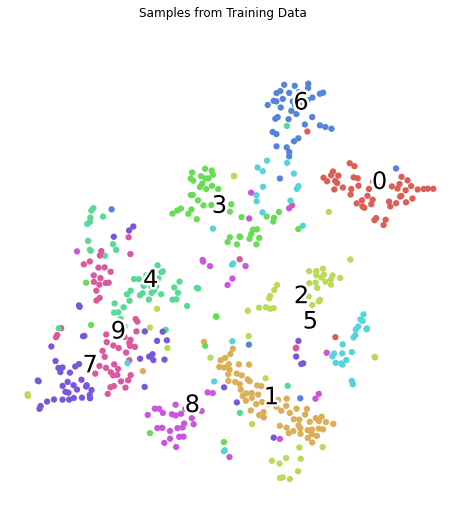

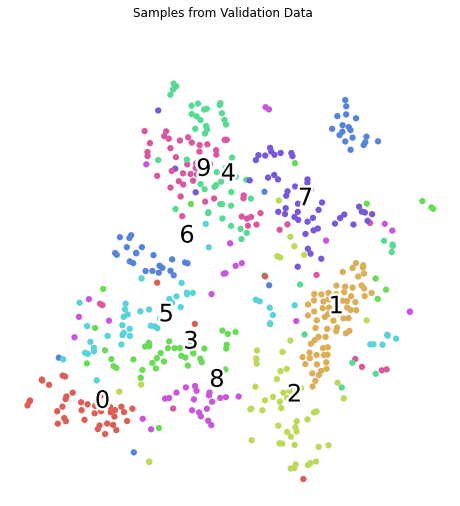

In [9]:
tsne = TSNE()
train_tsne_embeds = tsne.fit_transform(x_train_flat[:512])
scatter(train_tsne_embeds, y_train[:512], "Samples from Training Data")

eval_tsne_embeds = tsne.fit_transform(x_test_flat[:512])
scatter(eval_tsne_embeds, y_test[:512], "Samples from Validation Data")

# Generate Tripplet

In [10]:
def generate_triplet(x,y,testsize=0.3,ap_pairs=10,an_pairs=10):
    data_xy = tuple([x,y])

    trainsize = 1-testsize

    triplet_train_pairs = []
    triplet_test_pairs = []
    for data_class in sorted(set(data_xy[1])):

        same_class_idx = np.where((data_xy[1] == data_class))[0]
        diff_class_idx = np.where(data_xy[1] != data_class)[0]
        A_P_pairs = random.sample(list(permutations(same_class_idx,2)),k=ap_pairs) #Generating Anchor-Positive pairs
        Neg_idx = random.sample(list(diff_class_idx),k=an_pairs)
        

        #train
        A_P_len = len(A_P_pairs)
        Neg_len = len(Neg_idx)
        for ap in A_P_pairs[:int(A_P_len*trainsize)]:
            Anchor = data_xy[0][ap[0]]
            Positive = data_xy[0][ap[1]]
            for n in Neg_idx:
                Negative = data_xy[0][n]
                triplet_train_pairs.append([Anchor,Positive,Negative])               
        #test
        for ap in A_P_pairs[int(A_P_len*trainsize):]:
            Anchor = data_xy[0][ap[0]]
            Positive = data_xy[0][ap[1]]
            for n in Neg_idx:
                Negative = data_xy[0][n]
                triplet_test_pairs.append([Anchor,Positive,Negative])    
                
    return np.array(triplet_train_pairs), np.array(triplet_test_pairs)

In [11]:
X_train, X_test = generate_triplet(x_train_flat,y_train, ap_pairs=150, an_pairs=150,testsize=0.2)
print(X_train.shape)
print(X_test.shape)

(180000, 3, 784)
(45000, 3, 784)


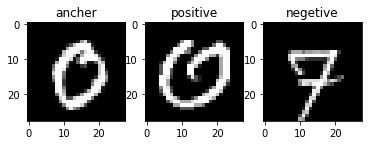

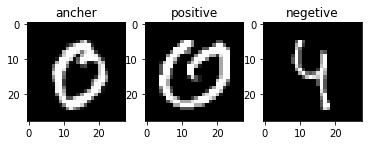

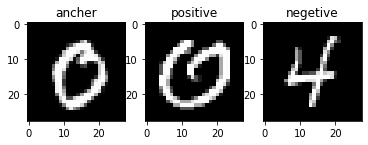

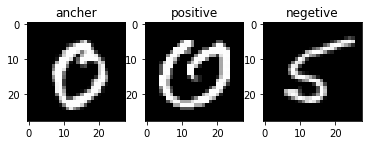

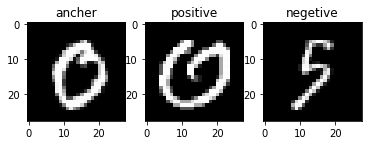

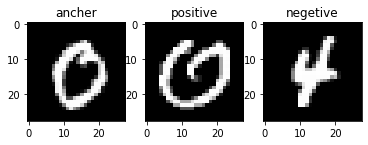

In [12]:
import copy

x=copy.deepcopy(X_train[100:106])
for i in range(len(x)):
    fig, ax =plt.subplots(1, 3)
    ax[0].imshow(x[i][0].reshape((28, 28)), cmap='gray')
    ax[0].set_title('ancher')
    ax[1].imshow(x[i][1].reshape((28, 28)), cmap='gray')
    ax[1].set_title('positive')
    ax[2].imshow(x[i][2].reshape((28, 28)), cmap='gray')
    ax[2].set_title('negetive')


In [13]:
#added cell
temp = []
X_train = X_train.transpose(1, 0, 2).reshape((3, 180000, 28, 28))
X_test = X_test.transpose(1, 0, 2).reshape((3, 45000, 28, 28))
temp.append(X_train[0])
temp.append(X_train[1])
temp.append(X_train[2])
temp.append(X_test[0])
temp.append(X_test[1])
temp.append(X_test[2])

X_train = temp[0:3]
X_test = temp[3:6]

print(len(X_train), X_train[0].shape)
print(len(X_test), X_test[0].shape)

3 (180000, 28, 28)
3 (45000, 28, 28)


# Tripplet Loss

In [14]:
def triplet_loss(y_pred, alpha=0.4):
    anch, pos, neg = y_pred
    return K.maximum(K.sum(K.square(anch-pos),axis=1) - K.sum(K.square(anch-neg),axis=1) + alpha, 0)

In [15]:
#added cell
def mean_triplet_loss(y_true, y_pred):
    return K.mean(y_pred)

# Embedding Predictions Network

In [22]:
def embedding_pred_net(dim = (28,28,1)):
    return Sequential([
                       Input(dim),
                       Conv2D(8, (3,3), activation='relu', padding='same'),
                       Conv2D(16, (3,3), activation='relu'),
                       MaxPooling2D(),
                       Conv2D(32, (3,3), activation='relu'),
                       Flatten(),
                       Dense(128, activation='relu'),
                       Dense(10)
    ])

# Siamese Network

In [23]:
anchor_in = Input((28,28,1, ), name='input-anchor')
positive_in = Input((28,28,1, ), name='input-positive')
negative_in = Input((28,28,1, ), name='input-negative')

# Shared embedding layer for positive and negative items
embedding_net = embedding_pred_net()

anchor_embedding = embedding_net(anchor_in)
positive_embedding = embedding_net(positive_in)
negative_embedding = embedding_net(negative_in)

merged_vector = Lambda(triplet_loss)([anchor_embedding, positive_embedding, negative_embedding])

model = Model(inputs=[anchor_in,positive_in, negative_in], outputs=merged_vector)

adam_optim = Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999)
model.compile(loss=mean_triplet_loss, optimizer=adam_optim)

model.summary()


Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input-anchor (InputLayer)      [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 input-positive (InputLayer)    [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 input-negative (InputLayer)    [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 sequential_2 (Sequential)      (None, 10)           502922      ['input-anchor[0][0]',           
                                                                  'input-positive[0][0]',   

# Training

In [18]:
model.fit(
    x= X_train,
    y= np.zeros(X_train[0].shape[0]),
    batch_size= 128,
    epochs= 5,
    validation_data = [X_test, np.zeros(X_test[0].shape[0])]
)

Epoch 1/5
1407/1407 [==============================] - 38s 21ms/step - loss: 0.0139 - val_loss: 0.0177
Epoch 2/5
1407/1407 [==============================] - 28s 20ms/step - loss: 4.3228e-04 - val_loss: 0.0240
Epoch 3/5
1407/1407 [==============================] - 29s 20ms/step - loss: 3.6115e-04 - val_loss: 0.0191
Epoch 4/5
1407/1407 [==============================] - 28s 20ms/step - loss: 2.2195e-04 - val_loss: 0.0172
Epoch 5/5
1407/1407 [==============================] - 28s 20ms/step - loss: 1.7126e-04 - val_loss: 0.0230


# Visualize Data Using t-SNE

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


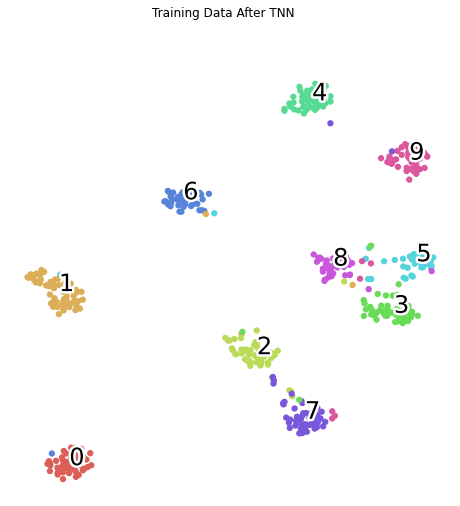

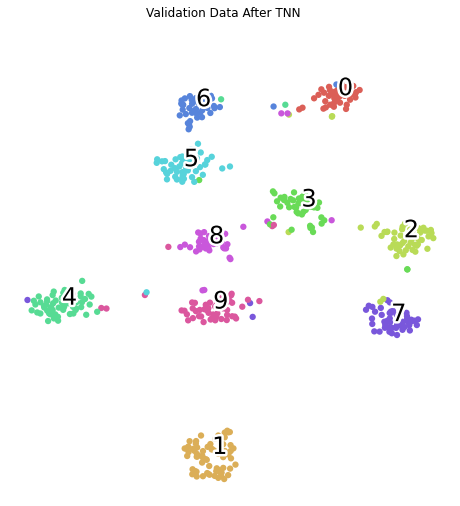

In [19]:
trained_model = Model(inputs=anchor_in, outputs=anchor_embedding)


train_trm = trained_model.predict(x_train[:512])
test_trm = trained_model.predict(x_test[:512])
tsne = TSNE()
train_tsne_embeds = tsne.fit_transform(train_trm)
scatter(train_tsne_embeds, y_train[:512], "Training Data After TNN")
eval_tsne_embeds = tsne.fit_transform(test_trm)
scatter(eval_tsne_embeds, y_test[:512], "Validation Data After TNN")